In [1]:
import os
import numpy as np
import pandas as pd
from numpy.linalg import inv
from numpy.matlib import repmat

np.seterr(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None 

In [2]:
import sys
sys.path.append('../../Python/')
from Preprocessing import standardize, MaxMinScaler
from Evaluation import split_train_test_ma, train_model, eval_model_roc_2, split_train_test_ma_rd
from Databases import get_databases_path, get_database

In [3]:
def sigmoid(a):
    return 1./(1 + np.exp(-a))

def train_lfc_model(X_train, y_train):
    X = X_train.copy(deep=True)
    Y = y_train.copy(deep=True)
    
    X.loc[:,'b'] = 0.0
    R = Y.shape[1] # Number of annotators.
    D = X.shape[1] # Input space dimension
    N = X.shape[0] # Number of samples.
    
    # Parameters initialization
    loglik1 = 10000000
    difloglik = 1
    difloglik1 = -1
    mui = np.array(Y.mean(axis=1)).reshape(Y.shape[0],1)

    w = np.dot(inv(np.dot(X.T,X) + 1e-20*np.eye(D)), np.dot(X.T,mui))
    i = 0
    
    while abs(difloglik) > 0.2 and i<100: 
        # M-step
        # We initialize the optimization parameters w.
        pi = sigmoid(np.dot(X,w))   
        gr = np.dot(X.T, (mui - pi))

        diag_aux = np.multiply(pi,(1-pi))
        diag = diag_aux*np.identity(len(diag_aux))

        H  = np.dot(np.dot(-X.T,diag),X)
        w  = w - np.dot(inv(H + 1e-20*np.eye(D)),gr)

        alpha = np.multiply(repmat(mui,1,R),Y).sum()/mui.sum()
        beta =  np.multiply(repmat((1-mui),1,R),(1-Y)).sum()/(1-mui).sum()

        # E-step
        pi = sigmoid(np.dot(X,w))  
        ai = np.multiply(np.power(repmat(alpha,N,1),Y),np.power(repmat((1-alpha),N,1),(1-Y)))
        ai = np.array(np.prod(ai, axis=1)).reshape(ai.shape[0],1)

        bi = np.multiply(np.power(repmat(beta,N,1),(1-Y)), np.power(repmat((1-beta),N,1),Y))
        bi = np.array(np.prod(bi, axis=1)).reshape(ai.shape[0],1)

        mui = np.multiply(ai, pi)/(np.multiply(ai,pi) + np.multiply(bi,(1 - pi)))

        # Logaritmic difference
        loglik2 = -(np.log(np.multiply(ai, pi) + np.multiply((1-pi),bi)).sum())
        difloglik = abs(loglik2 - loglik1)
        difloglik1 = (loglik2 - loglik1)
        loglik1 = loglik2
        
        i+=1    
    return w, alpha, beta 

------------------------------------------------------------------------
Database: ../../Databases/Sinteticas/breast-cancer 


 Results 

-- Global Precision --
0.8888888888888888


-- General Report --
              precision    recall  f1-score   support

         yes       0.94      0.88      0.91       108
          no       0.81      0.90      0.86        63

    accuracy                           0.89       171
   macro avg       0.88      0.89      0.88       171
weighted avg       0.89      0.89      0.89       171



-- Confusion Matrix --
    0   1
0  95  13
1   6  57

ROC Curve: 

ROC AUC:  0.9158583186360965


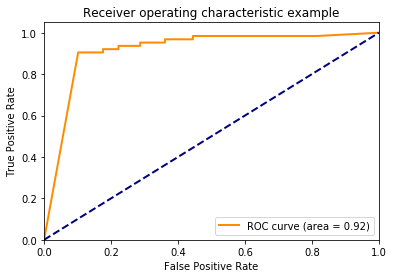

------------------------------------------------------------------------
Database: ../../Databases/Sinteticas/column 


 Results 

-- Global Precision --
0.8064516129032258


-- General Report --
              precision    recall  f1-score   support

         yes       0.89      0.81      0.85        63
          no       0.67      0.80      0.73        30

    accuracy                           0.81        93
   macro avg       0.78      0.80      0.79        93
weighted avg       0.82      0.81      0.81        93



-- Confusion Matrix --
    0   1
0  51  12
1   6  24

ROC Curve: 

ROC AUC:  0.9169312169312169


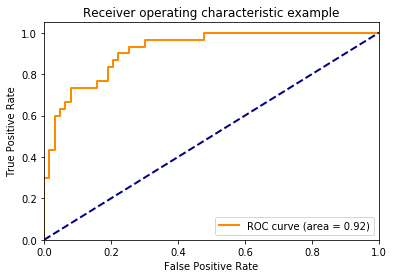

------------------------------------------------------------------------
Database: ../../Databases/Sinteticas/parkinsons 


 Results 

-- Global Precision --
0.7796610169491526


-- General Report --
              precision    recall  f1-score   support

         yes       0.87      0.85      0.86        46
          no       0.50      0.54      0.52        13

    accuracy                           0.78        59
   macro avg       0.68      0.69      0.69        59
weighted avg       0.79      0.78      0.78        59



-- Confusion Matrix --
    0  1
0  39  7
1   6  7

ROC Curve: 

ROC AUC:  0.7408026755852842


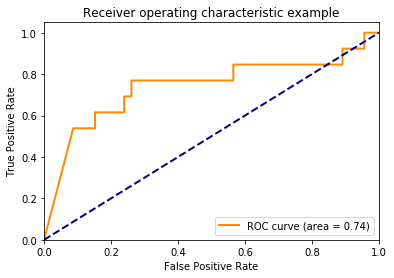

------------------------------------------------------------------------
Database: ../../Databases/Sinteticas/ionophere 


 Results 

-- Global Precision --
0.7333333333333333


-- General Report --
              precision    recall  f1-score   support

         yes       0.61      0.68      0.64        37
          no       0.81      0.76      0.79        68

    accuracy                           0.73       105
   macro avg       0.71      0.72      0.71       105
weighted avg       0.74      0.73      0.74       105



-- Confusion Matrix --
    0   1
0  25  12
1  16  52

ROC Curve: 

ROC AUC:  0.791335453100159


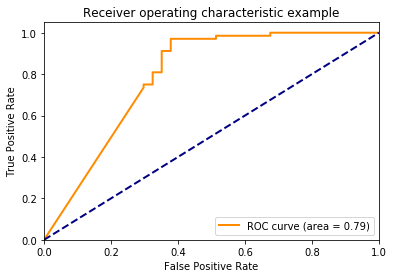

------------------------------------------------------------------------
Database: ../../Databases/Sinteticas/sentiment-polarity 


 Results 

-- Global Precision --
0.6190476190476191


-- General Report --
              precision    recall  f1-score   support

         yes       0.59      0.54      0.57        48
          no       0.64      0.68      0.66        57

    accuracy                           0.62       105
   macro avg       0.62      0.61      0.61       105
weighted avg       0.62      0.62      0.62       105



-- Confusion Matrix --
    0   1
0  26  22
1  18  39

ROC Curve: 

ROC AUC:  0.6816520467836257


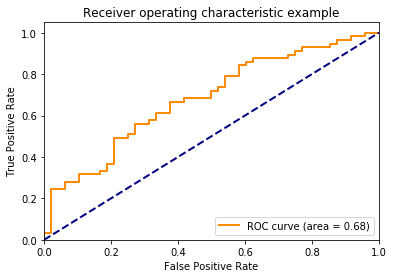

In [4]:
databases_path = '../../Databases/Sinteticas'
paths = get_databases_path(databases_path)

for database in paths:
    print('------------------------------------------------------------------------')
    print("Database:", database, '\n')
    
    # Obtain the attributes and labels
    attr_df = get_database(database, 'database_attr.csv')
    labels_df = get_database(database, 'database_labels.csv')  
    
    # Preprocessing the attributes
    attr_df = MaxMinScaler(attr_df)
    
    # Split in Training and Test Sets
    X_train, X_test, y_train, y_test = split_train_test_ma(attr_df, labels_df)
    
    # Train LFC Model
    W, alpha, beta = train_lfc_model(X_train, y_train)
    
    X_test.loc[:,'b'] = 0.0
    predtest = sigmoid(np.dot(X_test,W))
    y_pred = np.round(predtest).astype(bool)
    
    print("\n Results \n")
    eval_model_roc_2(y_test, y_pred, predtest)